# Stack Overflow Developer Survey 2023 Data Analysis

## Introduction

In this notebook, we'll delve into the insights of the Stack Overflow Developer Survey 2023 data, leveraging a comprehensive Machine Learning Pipeline for analysis and employing robust Model Evaluation techniques

#### Data Collection
- Dataset Source - https://insights.stackoverflow.com/survey 

#### Setup
Ensure that you have the necessary tools and libraries installed. You may use Python with Pandas, NumPy, and other relevant libraries.

In [1]:
import time
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


#### Data Loading

In [2]:
df = pd.read_csv("survey_results_public.csv")

#### Selecting Relevant Columns

In [3]:
selected_columns = ['Country', 'Age', 'EdLevel', 'Employment', 'RemoteWork', 'DevType', 'OrgSize',  'YearsCodePro', 'ConvertedCompYearly']
df = df[selected_columns]

#### Initial Data Exploration

In [4]:
df1 = df.copy()

In [5]:
def explore_column(data, column, threshold=10):

    # Select the specified column
    column_data = data[column]

    # Calculate the number of null values in the column
    num_null = column_data.isnull().sum()

    # Calculate the number of unique values in the column
    num_unique = column_data.nunique()

    # Print the analysis results
    print(f"Exploring column '{column}':")
    print(f"  Number of null values: {num_null}")
    print(f"  Number of unique values: {num_unique}")

    # If the number of unique values is less than or equal to the threshold, display them and their counts
    if num_unique <= threshold:
        unique_values = column_data.unique()
        value_counts = column_data.value_counts()

        print(f"  Unique values: {unique_values}")
        print("  Value counts:")
        for value, count in value_counts.items():
            print(f"               {value}: {count}")


explore_column(df1, "Country") 
print("\n")
explore_column(df1, "Age")
print("\n")
explore_column(df1, "EdLevel")
print("\n")
explore_column(df1, "Employment")
print("\n")
explore_column(df1, "RemoteWork")
print("\n")
explore_column(df1, "DevType")
print("\n")
explore_column(df1, "OrgSize")

Exploring column 'Country':
  Number of null values: 1211
  Number of unique values: 185


Exploring column 'Age':
  Number of null values: 0
  Number of unique values: 8
  Unique values: ['18-24 years old' '25-34 years old' '45-54 years old' '35-44 years old'
 'Under 18 years old' '55-64 years old' '65 years or older'
 'Prefer not to say']
  Value counts:
               25-34 years old: 33247
               35-44 years old: 20532
               18-24 years old: 17931
               45-54 years old: 8334
               Under 18 years old: 4128
               55-64 years old: 3392
               65 years or older: 1171
               Prefer not to say: 449


Exploring column 'EdLevel':
  Number of null values: 1211
  Number of unique values: 8
  Unique values: [nan 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)'
 'Some college/university study without earning a degree'
 'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)'
 'Primary/elementary school'
 'Professional degree (JD, MD, Ph.D, Ed.

#### Data Cleaning

In [6]:
df1['YearsCodePro'] = pd.to_numeric(df1['YearsCodePro'], errors='coerce')
df1.rename(columns={'ConvertedCompYearly': 'Salary'}, inplace=True)

In [7]:
df1 = df1[df1["Employment"]=="Employed, full-time"]
df1 = df1.drop("Employment",axis=1)

In [8]:
df1 = df1[df1["Salary"].notnull()]

In [9]:
df1 = df1[~df1['Age'].isin(['Prefer not to say'])]
df1 = df1[~df1['OrgSize'].isin(['I don’t know'])]

In [10]:
# Display null value counts before using dropna()
print('Null values before using dropna():')
print(df1.isnull().sum())
print('\n')

# Drop rows with any remaining null values
df1 = df1.dropna()

# Display null value counts after using dropna()
print('\nNull values after using dropna():')
print(df1.isnull().sum())
print('\n')
print(f"Total null values after dropna(): {df1.isnull().sum().sum()}")

Null values before using dropna():
Country            0
Age                0
EdLevel            0
RemoteWork         0
DevType           29
OrgSize           31
YearsCodePro    1174
Salary             0
dtype: int64



Null values after using dropna():
Country         0
Age             0
EdLevel         0
RemoteWork      0
DevType         0
OrgSize         0
YearsCodePro    0
Salary          0
dtype: int64


Total null values after dropna(): 0


#### Categorical Column Mapping

In [11]:
def replace_column_values(column, value_mapping=None, threshold=None, replacement='other'):
    column = column.replace(value_mapping)

    if threshold is not None:
        value_counts = column.value_counts()
        to_replace = value_counts[value_counts < threshold].index
        column = column.replace(to_replace, replacement)

    return column

YearsCodePro_mapping = {'More than 50 years': 50, 'Less than 1 year': 0.5}

DevType_mapping = {'Other (please specify):': 'other'}

EdLevel_mapping = {
        'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 'Bachelor’s degree',
        'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 'Master’s degree',
        'Professional degree (JD, MD, Ph.D, Ed.D, etc.)': 'Doctoral degree',
        'Associate degree (A.A., A.S., etc.)': 'Associate degree',
        'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 'Non-degree',
        'Some college/university study without earning a degree': 'Non-degree',
        'Primary/elementary school': 'Non-degree',
        'Something else ': 'Non-degree',
}

OrgSize_mapping = {
        '2 to 9 employees': 'Small Business',
        '10 to 19 employees': 'Small Business',
        '20 to 99 employees': 'Small Business',
        '100 to 499 employees': 'Medium Business',
        '500 to 999 employees': 'Medium Business',
        '1,000 to 4,999 employees': 'Large Business',
        '5,000 to 9,999 employees': 'Large Business',
        '10,000 or more employees': 'Large Business',
        'Just me - I am a freelancer, sole proprietor, etc.': 'Freelancer'
}



df1["Country"] = replace_column_values(df1["Country"], threshold=50)
df1["DevType"] = replace_column_values(df1["DevType"], DevType_mapping, threshold=50)
df1["EdLevel"] = replace_column_values(df1["EdLevel"], EdLevel_mapping)
df1["YearsCodePro"] = replace_column_values(df1["YearsCodePro"], YearsCodePro_mapping)
df1["OrgSize"] = replace_column_values(df1["OrgSize"], OrgSize_mapping)

#### Outlier Handling

In [12]:
def boxplot_by_category(data, y_column, x_column, width, height, show_outliers=True):
    plt.figure(figsize=(width, height))
    sns.set_theme(style="darkgrid")

    boxprops = dict(linestyle='-', linewidth=2, edgecolor='skyblue', facecolor='lightcyan')
    medianprops = dict(linestyle='-', linewidth=2, color='lightcoral')



    if not show_outliers:
        sns.boxplot(x=x_column, y=y_column, data=data, boxprops=boxprops, medianprops=medianprops, showfliers=False)
    else:
        sns.boxplot(x=x_column, y=y_column, data=data, boxprops=boxprops, medianprops=medianprops)

    plt.title(f"Boxplot of {y_column} by {x_column}", fontsize=18)
    plt.xlabel(x_column, fontsize=16)
    plt.ylabel(y_column, fontsize=16)
    plt.xticks(rotation=90)

    plt.show()



def cap_outliers_by_group(data, y_column, x_column):
    # Group by 'x_column' and compute the 25th and 75th percentiles for 'y_column'
    summary_stats = data.groupby(x_column)[y_column].describe().reset_index()[[x_column, '25%', '75%']]
    
    # Merge the percentiles back into the original DataFrame
    df_with_stats = data.merge(summary_stats, on=x_column, how="left")
    
    # Replace outliers with corresponding percentiles
    mask_low = df_with_stats[y_column] < df_with_stats['25%']
    df_with_stats.loc[mask_low, y_column] = df_with_stats['25%']
    
    mask_high = df_with_stats[y_column] > df_with_stats['75%']
    df_with_stats.loc[mask_high, y_column] = df_with_stats['75%']

    # Drop the columns '25%' and '75%' from the DataFrame 
    df_with_stats.drop(['25%','75%'],axis=1,inplace=True)
    
    return df_with_stats

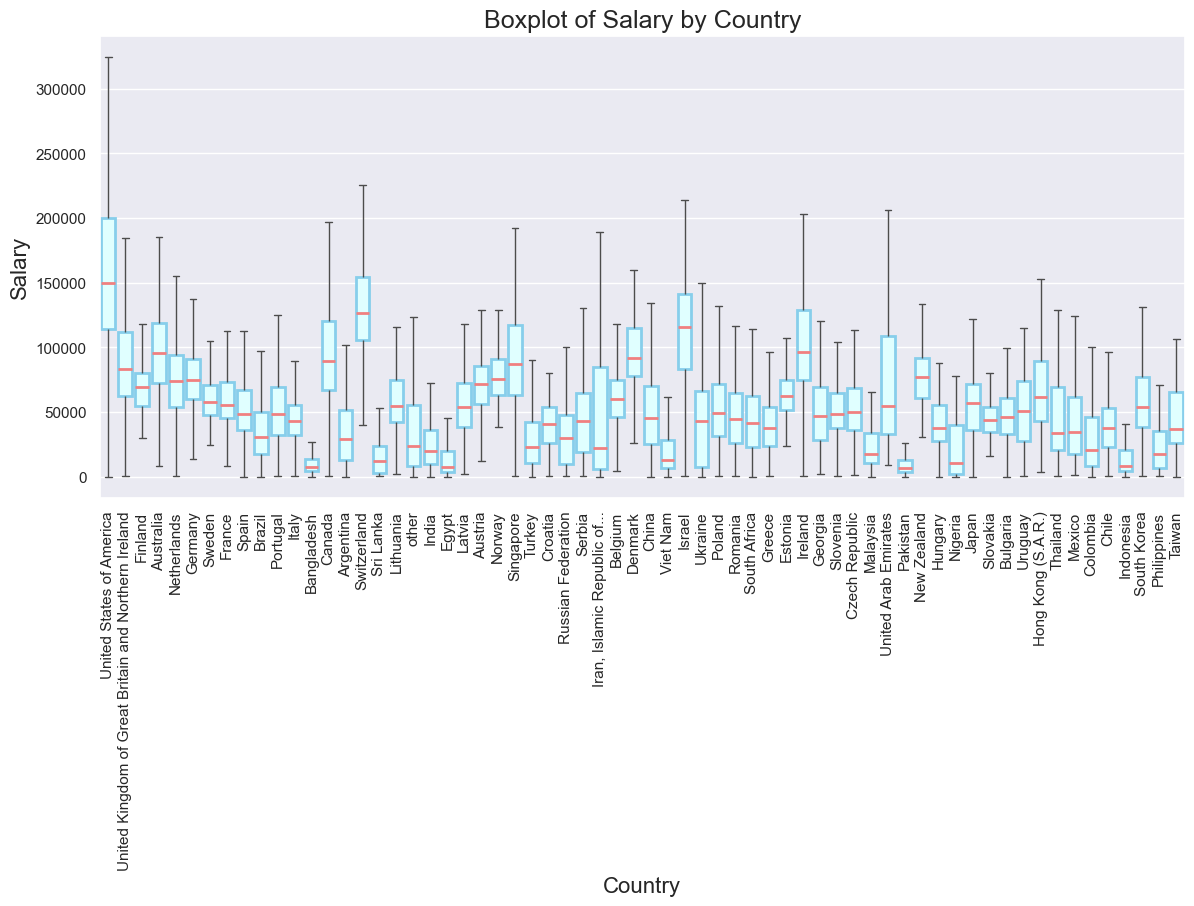

In [13]:
boxplot_by_category(df1, "Salary", "Country", width=14, height=6, show_outliers=False)

In [14]:
df1 = cap_outliers_by_group(df1, 'Salary', 'Country')

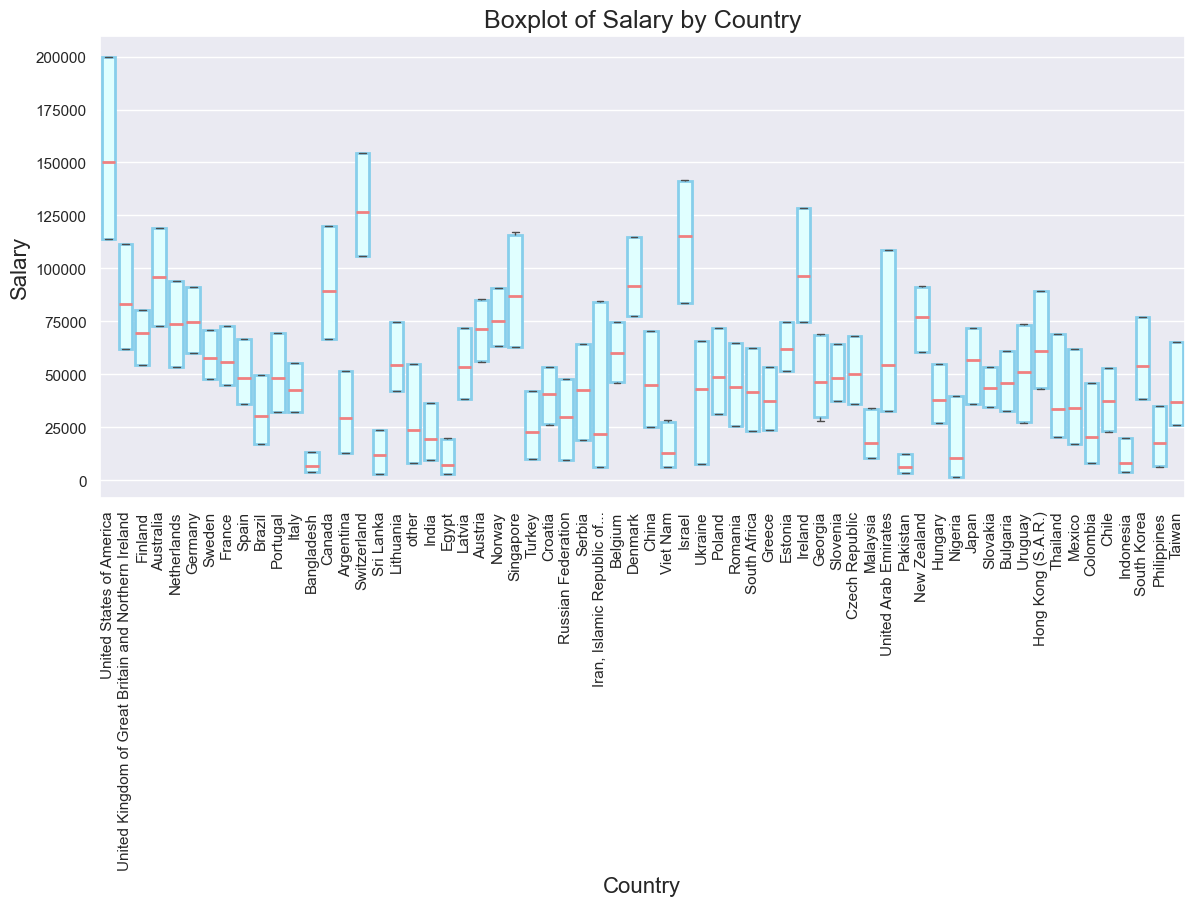

In [15]:
boxplot_by_category(df1, "Salary", "Country", width=14, height=6, show_outliers=False)

In [16]:
print(df1.info())
print('\n')
df1.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37594 entries, 0 to 37593
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       37594 non-null  object 
 1   Age           37594 non-null  object 
 2   EdLevel       37594 non-null  object 
 3   RemoteWork    37594 non-null  object 
 4   DevType       37594 non-null  object 
 5   OrgSize       37594 non-null  object 
 6   YearsCodePro  37594 non-null  float64
 7   Salary        37594 non-null  float64
dtypes: float64(2), object(6)
memory usage: 3.6+ MB
None




,Country,Age,EdLevel,RemoteWork,DevType,OrgSize,YearsCodePro,Salary
29750,Singapore,18-24 years old,Master’s degree,Remote,"Developer, back-end",Small Business,2.0,62995.0
15784,New Zealand,25-34 years old,Master’s degree,"Hybrid (some remote, some in-person)","Developer, full-stack",Small Business,8.0,60702.0
28096,Malaysia,45-54 years old,Bachelor’s degree,"Hybrid (some remote, some in-person)",Security professional,Large Business,23.0,17473.0
29792,Switzerland,35-44 years old,Master’s degree,In-person,other,Large Business,14.0,154303.0
17734,Poland,35-44 years old,Bachelor’s degree,"Hybrid (some remote, some in-person)","Developer, front-end",Large Business,5.0,71779.0


## Machine Learning Pipeline and Model Evaluation

#### Data Preprocessing Pipeline

In [17]:
# Separate features (X) and target variable (y)
X = df1.drop("Salary", axis=1)
y = df1["Salary"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=42)

In [18]:
# Define a pipeline for one-hot encoding categorical features
categorical_transformer = Pipeline([
    ('one_hot_encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Define the original columns in your dataset
original_columns = ['Country', 'Age', 'EdLevel', 'RemoteWork', 'DevType', 'OrgSize', 'YearsCodePro']

# Create a ColumnTransformer to apply the categorical transformer to specific columns
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, original_columns)
    ],
    remainder='passthrough'
)

# Create the overall data processing pipeline
data_processing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])


# Fiting and tarnsforming the data processing pipeline to the training data
X_train = data_processing_pipeline.fit_transform(X_train)



# Tarnsforming the data processing pipeline to the test data
X_test = data_processing_pipeline.transform(X_test)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Create a Linear Regression model
lm = LinearRegression()

# Train the model on the training data
lm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lm.predict(X_test)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Display the evaluation metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 14813.454476950355
Root Mean Squared Error: 19317.7514784319
R2 Score: 0.859060318758468


#### Model Comparison and Hyperparameter Tuning

The code employs the pycaret library for model comparison and selection. It compares the performance of different regression models and selects the top 5 based on their performance.

In [20]:
import  pycaret
from pycaret.regression import *
setup(df1, target = "Salary", session_id = 1)

,Description,Value
0,Session id,1
1,Target,Salary
2,Target type,Regression
3,Original data shape,"(37594, 8)"
4,Transformed data shape,"(37594, 24)"
5,Transformed train set shape,"(26315, 24)"
6,Transformed test set shape,"(11279, 24)"
7,Numeric features,1
8,Categorical features,6
9,Preprocess,True


In [21]:
# Compare models and get top 5
top_5_models = compare_models(n_select=5)

# Retrieve and display parameters for each model
for idx, model in enumerate(top_5_models, 1):
    print(f"Model {idx}: {type(model).__name__}")
    print("Parameters:", model.get_params())
    print("_" * 90)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,14407.4464,371976114.4014,19283.7339,0.8647,0.2969,0.2384,3.3830
gbr,Gradient Boosting Regressor,14833.3174,378107139.8311,19442.4390,0.8625,0.3028,0.2483,1.1200
xgboost,Extreme Gradient Boosting,14557.6163,385786742.4000,19638.6482,0.8596,0.3020,0.2402,0.3560
lasso,Lasso Regression,15928.8825,417368450.6337,20427.4655,0.8482,0.3484,0.2676,0.5150
ridge,Ridge Regression,15928.4491,417361070.2099,20427.2839,0.8482,0.3482,0.2676,0.1760
llar,Lasso Least Angle Regression,15928.8825,417368450.6331,20427.4655,0.8482,0.3484,0.2676,0.1710
br,Bayesian Ridge,15931.4957,417391549.7473,20428.0502,0.8482,0.3493,0.2677,0.2110
lr,Linear Regression,15928.0771,417360784.6971,20427.2744,0.8482,0.3482,0.2676,0.8470
en,Elastic Net,16584.5731,441485225.3282,21009.8869,0.8394,0.3392,0.2729,0.1870
rf,Random Forest Regressor,15281.7890,444455982.0765,21079.1512,0.8383,0.3161,0.2520,4.4590


Model 1: CatBoostRegressor
Parameters: {'loss_function': 'RMSE', 'border_count': 254, 'verbose': False, 'task_type': 'CPU', 'random_state': 1}
__________________________________________________________________________________________
Model 2: GradientBoostingRegressor
Parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 1, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
__________________________________________________________________________________________
Model 3: XGBRegressor
Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynod

#### Hyperparameter Tuning and Model Training

In [22]:
models = {
    "CatBoost": (CatBoostRegressor(verbose=False), {
        'depth': [6, 8, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'l2_leaf_reg': [3, 5, 7],
    }),
    "GradientBoosting": (GradientBoostingRegressor(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
    }),
    "XGBoost": (XGBRegressor(), {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': [50, 100, 200],
    }),
}


def parameter_finder(model_name, model, parameters, i, search_type='grid'):
    if search_type == 'grid':
        # Use Grid Search
        search_cv = GridSearchCV
        search_params = {'param_grid': parameters}
    elif search_type == 'random':
        # Use Randomized Search
        search_cv = RandomizedSearchCV
        search_params = {'param_distributions': parameters}
    else:
        raise ValueError("Invalid search_type. Use 'grid' or 'random'.")

    # Initialize a Grid Search or Randomized Search with cross-validation to find the best hyperparameters
    search = search_cv(model,
                       refit=True,
                       cv=KFold(shuffle=True, random_state=i),
                       n_jobs=-1,
                       **search_params)  

    # Capture the start time for training duration calculation
    start_time = time.time()

    # Fit the Search on training data
    search_fit = search.fit(X_train, y_train)

    # Calculate and print the training time
    end_time = time.time()
    training_time = end_time - start_time
    print(f'{i}) Model: {model_name}, Training Time (seconds): {training_time}')

    # Predict using the best estimator found by Search on training and test data
    y_train_pred = search_fit.predict(X_train)
    y_pred = search_fit.predict(X_test)

    # Store results in a dictionary
    result_dict = {
        'Model Name': model.__class__.__name__,
        'Best Parameters': search.best_params_,
        'Train Score': search_fit.score(X_train, y_train),
        'Test Score': search_fit.score(X_test, y_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }
    return result_dict

# Loop through each model, find the best parameters, and store the results in the all_results dictionary
all_results = {}
for i, (model_name, (model, params)) in enumerate(models.items(), 1):
    result_dict = parameter_finder(model_name, model, params, i)
    all_results[model_name] = result_dict

all_results

1) Model: CatBoost, Training Time (seconds): 910.9050667285919
2) Model: GradientBoosting, Training Time (seconds): 3280.9444007873535
3) Model: XGBoost, Training Time (seconds): 100.31814002990723


{'CatBoost': {'Model Name': 'CatBoostRegressor',
  'Best Parameters': {'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1},
  'Train Score': 0.8815539920195723,
  'Test Score': 0.8659044085987441,
  'RMSE': 18842.87565158149,
  'MAE': 14087.614005151272,
  'R2': 0.8659044085987441},
 'GradientBoosting': {'Model Name': 'GradientBoostingRegressor',
  'Best Parameters': {'learning_rate': 0.2,
   'max_depth': 5,
   'n_estimators': 200},
  'Train Score': 0.8798596409685957,
  'Test Score': 0.8646445932690497,
  'RMSE': 18931.182240911494,
  'MAE': 14219.196197612637,
  'R2': 0.8646445932690497},
 'XGBoost': {'Model Name': 'XGBRegressor',
  'Best Parameters': {'learning_rate': 0.2,
   'max_depth': 5,
   'n_estimators': 200},
  'Train Score': 0.8785125870792421,
  'Test Score': 0.8651616505546885,
  'RMSE': 18894.98911108467,
  'MAE': 14233.242379046502,
  'R2': 0.8651616505546885}}

#### Model Training and Evaluation

In [22]:
def get_feature_importance(model, pipeline, original_columns,
                            preprocessor_name='preprocessor',
                            categorical_name='categorical',
                            one_hot_name='one_hot_encode'):
    column_transformer = pipeline.named_steps[preprocessor_name]
    categorical_transformer = column_transformer.named_transformers_[categorical_name]
    one_hot_encoder = categorical_transformer.named_steps[one_hot_name]

    feature_importances = model.feature_importances_
    one_hot_feature_names = one_hot_encoder.get_feature_names_out()

    categorical_features = column_transformer.transformers_[0][2]
    numerical_features = [col for col in original_columns if col not in categorical_features]

    all_feature_names = np.concatenate([one_hot_feature_names, numerical_features])

    aggregated_importances = {}

    for col in original_columns:
        if col not in categorical_features:
            idx = np.where(all_feature_names == col)[0]
            if idx.size > 0:
                aggregated_importances[col] = feature_importances[idx[0]]
        else:
            indices = [i for i, s in enumerate(all_feature_names) if s.startswith(f"{col}_")]
            aggregated_importance = sum(feature_importances[i] for i in indices)
            aggregated_importances[col] = aggregated_importance

    sorted_importances = dict(sorted(aggregated_importances.items(), key=lambda item: item[1], reverse=True))

    return sorted_importances

In [23]:
# Define the models
gb_model = GradientBoostingRegressor(
   learning_rate= 0.2,
   max_depth= 5,
   n_estimators= 200    
)

xgb_model = XGBRegressor(
   learning_rate= 0.2,
   max_depth= 5,
   n_estimators= 200,
)

catboost_model = CatBoostRegressor(
   depth= 6,
   l2_leaf_reg= 5,
   learning_rate= 0.1,
   verbose=False  
)



# Create a dictionary to loop over
models = {
    "GradientBoosting": gb_model,
    "XGBoost": xgb_model,
    "CatBoost": catboost_model
}


original_columns = ['Country', 'Age', 'EdLevel', 'RemoteWork', 'DevType', 'OrgSize', 'YearsCodePro']

# Train the models and evaluate their performance
for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    
    print(f"{model_name} - Train MSE: {train_mse}, Train R²: {train_r2}")
    print(f"{model_name} - Test MSE: {test_mse}, Test R²: {test_r2}")
    print()

    
    aggregated_importances = get_feature_importance(model, data_processing_pipeline, original_columns)
    # Printing each feature and its importance on a new line
    print(f"Feature importance of {model_name} : ")
    for feature, importance in aggregated_importances.items():
        print(f"{feature}: {importance}") 
    print('\n' * 2)

GradientBoosting - Train MSE: 329379787.72098625, Train R²: 0.8798596409685957
GradientBoosting - Test MSE: 358389661.0386027, Test R²: 0.8646445932690497

Feature importance of GradientBoosting : 
Country: 0.9135747569303686
YearsCodePro: 0.03671254377263857
DevType: 0.017258790179955907
Age: 0.01471313881884242
OrgSize: 0.008108406207444274
RemoteWork: 0.005931267890942799
EdLevel: 0.0037010961998074627



XGBoost - Train MSE: 333072904.0700731, Train R²: 0.8785125870792421
XGBoost - Test MSE: 357020613.5080082, Test R²: 0.8651616505546885

Feature importance of XGBoost : 
Country: 0.9039247486944078
YearsCodePro: 0.044405570028175134
DevType: 0.03184328431962058
Age: 0.008776897913776338
OrgSize: 0.004668505862355232
EdLevel: 0.0035295128473080695
RemoteWork: 0.002851527096936479



CatBoost - Train MSE: 324734512.8608571, Train R²: 0.8815539920195723
CatBoost - Test MSE: 355053962.8209625, Test R²: 0.8659044085987441

Feature importance of CatBoost : 
Country: 89.4228818472912
Year

#### Model Deployment and Prediction

In [38]:
# save the model
model_name = "CatBoost"
joblib.dump(catboost_model, f"{model_name}_model.joblib")

# Save the pipeline to a file
joblib.dump(data_processing_pipeline, 'preprocessor.joblib')

['preprocessor.joblib']

In [60]:
# Load the model and preprocessor
model = joblib.load('CatBoost_model.joblib')
preprocessor = joblib.load('preprocessor.joblib')

# Example new data (replace this with your actual data)
new_data = {
    'Country': 'Canada',
    'Age': '35-44 years old',
    'EdLevel': 'Master’s degree',
    'RemoteWork': 'Remote',
    'DevType': 'Developer, full-stack',
    'OrgSize': 'Small Business',
    'YearsCodePro': 5
}

# Convert the new data into a format suitable for prediction
new_data_df = pd.DataFrame([new_data])

# Use the preprocessor to transform the new data
new_data_processed = preprocessor.transform(new_data_df)

# Make predictions using the trained model
predicted_salary = model.predict(new_data_processed)

# Print the predicted salary
print("Predicted Salary:", predicted_salary[0])

Predicted Salary: 85972.88973992769


#### Neural Network Model Training

In [53]:
modelNN = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# Compile the model
modelNN.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
modelNN.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.15)

Epoch 1/30
849/849 [==============================] - 3s 3ms/step - loss: 6965840384.0000 - val_loss: 2388268288.0000
Epoch 2/30
849/849 [==============================] - 2s 3ms/step - loss: 1896493568.0000 - val_loss: 1466295040.0000
Epoch 3/30
849/849 [==============================] - 2s 2ms/step - loss: 1205101568.0000 - val_loss: 897092160.0000
Epoch 4/30
849/849 [==============================] - 2s 2ms/step - loss: 751777728.0000 - val_loss: 561568640.0000
Epoch 5/30
849/849 [==============================] - 2s 2ms/step - loss: 517070880.0000 - val_loss: 434743936.0000
Epoch 6/30
849/849 [==============================] - 2s 2ms/step - loss: 438716160.0000 - val_loss: 400812448.0000
Epoch 7/30
849/849 [==============================] - 2s 2ms/step - loss: 415294176.0000 - val_loss: 389652192.0000
Epoch 8/30
849/849 [==============================] - 2s 2ms/step - loss: 404872672.0000 - val_loss: 384985856.0000
Epoch 9/30
849/849 [==============================] - 2s 2ms/step -

In [55]:
# Evaluate the model on the test set
loss = modelNN.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

# Get predictions from your model
y_train_pred = modelNN.predict(X_train)
y_test_pred = modelNN.predict(X_test)

# Calculate R² score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print('Train R²:', r2_train)
print('Test R²:', r2_test)

177/177 [==============================] - 0s 2ms/step - loss: 357085536.0000
Mean Squared Error on Test Set: 357085536.0
177/177 [==============================] - 0s 2ms/step
Train R²: 0.8655463182614009
Test R²: 0.8651371340730574


In [61]:
# Make predictions using new_data
new_data = {
    'Country': 'Canada',
    'Age': '35-44 years old',
    'EdLevel': 'Master’s degree',
    'RemoteWork': 'Remote',
    'DevType': 'Developer, full-stack',
    'OrgSize': 'Small Business',
    'YearsCodePro': 5
}

models = {
    "GradientBoosting": gb_model,
    "XGBoost": xgb_model,
    "CatBoost": catboost_model,
    "Neural Network":modelNN,
}

# Convert the new data into a format suitable for prediction
new_data_df = pd.DataFrame([new_data])

# Use the preprocessor to transform the new data
new_data_processed = preprocessor.transform(new_data_df)


# Make predictions using the trained model
for model_name, model in models.items():
    prediction = model.predict(new_data_processed)
    print(f"{model_name} - Predicted Value: {prediction[0]}")

GradientBoosting - Predicted Value: 87599.46410599463
XGBoost - Predicted Value: 89711.703125
CatBoost - Predicted Value: 85972.88973992769
1/1 [==============================] - 0s 55ms/step
Neural Network - Predicted Value: [83760.08]


## Model Performance and Training Analysis

#### Traditional Machine Learning Models and Neural Network


- **CatBoost:** CatBoost performed admirably with a reasonable training time. It exhibited excellent generalization to the test set, showing high R² and relatively low RMSE.


- **GradientBoosting:** GradientBoosting, while performing well, had a longer training time compared to CatBoost. It achieved slightly lower R² and RMSE.


- **XGBoost:** XGBoost demonstrated strong performance with a short training time, akin to CatBoost. It achieved competitive results with high R² and relatively low RMSE.


- **Neural Network:** The neural network's performance was comparable to traditional machine learning models. It exhibited a good fit to the training data and generalization to the test set, indicated by high R² values. However, the test Mean Squared Error (MSE) provides additional insight into its performance on the test set.

#### General Comparison

- All models, including the neural network, performed well with R² values hovering around 86%.
- CatBoost and XGBoost showcased competitive results with relatively shorter training times compared to GradientBoosting.
- The neural network demonstrated effectiveness in capturing complex relationships in the data, showcasing comparable performance to traditional machine learning models.

**In summary,** each model has its strengths, and the choice between them may depend on factors such as training time, interpretability, and specific requirements of the problem at hand.
